In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [3]:
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [4]:
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading the Data

In [5]:
Loan_Details = pd.read_csv('Loan.csv')

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
Loan_Details.shape

(887379, 74)

In [7]:
Loan_Details.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dropping Features having more than 80% Missing Values

In [8]:
pct_null = Loan_Details.isnull().sum() / len(Loan_Details)
missing_features = pct_null[pct_null > 0.8].index
len(missing_features)

19

In [9]:
Loan_Details_Clean = Loan_Details.drop(missing_features,axis = 1)

In [10]:
Loan_Details_Clean.shape

(887379, 55)

# Imputing the Missing Values for the Remaining Features

In [11]:
pct_null = Loan_Details_Clean.isnull().sum() / len(Loan_Details_Clean)
missing_features = pct_null[pct_null > 0].index
len(missing_features)

20

In [12]:
Loan_Details_Clean[missing_features].dtypes

emp_title                       object
annual_inc                     float64
title                           object
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq         float64
open_acc                       float64
pub_rec                        float64
revol_util                     float64
total_acc                      float64
last_pymnt_d                    object
next_pymnt_d                    object
last_credit_pull_d              object
collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
total_rev_hi_lim               float64
dtype: object

In [13]:
for mf in missing_features:
    if Loan_Details_Clean[mf].dtypes == 'object':
        Loan_Details_Clean[mf].fillna(Loan_Details_Clean[mf].value_counts().index[0],inplace = True)
    else:
        Loan_Details_Clean[mf].fillna(Loan_Details_Clean[mf].median(),inplace = True)

# Final Check for Missing Values 

In [14]:
pct_null = Loan_Details_Clean.isnull().sum() / len(Loan_Details_Clean)
missing_features = pct_null[pct_null > 0].index
len(missing_features)

0

# Data Preprocessing

In [15]:
Loan_Details_Clean.drop(['id','member_id','url'], axis =1,inplace = True)

In [16]:
Loan_Details_Clean['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [17]:
Loan_Details_Clean['loan_status'].replace(('Does not meet the credit policy. Status:Fully Paid',
                            'Does not meet the credit policy. Status:Charged Off'),('Fully Paid','Charged Off'),inplace = True)

In [18]:
Loan_Details_Clean['loan_status'].replace(('Charged Off'),('Default'),inplace = True)

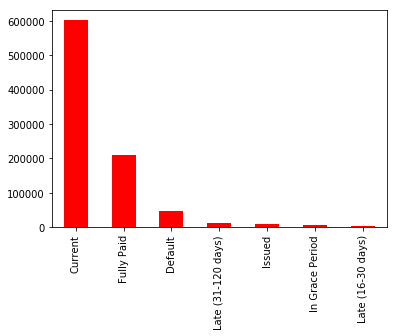

In [19]:
(Loan_Details_Clean['loan_status'].value_counts()).plot(kind='bar', color="red")

I removed the term 'Doesn't meet credit policy' as those loans were issued before the change in credit policy but the loan are exactly the same.
Next, I removed all the late loans, current loans and loans that are just being issued, as these fall into a certain grey area with ambiguous, undetermined final statuses. 
I next combined the “Default” loans with the “Charged Off” loans into one category of 'Default', leaving me with two final labels for my classification attempts - 'Fully Paid' or 'Default'.

In [20]:
Loan_details_final = Loan_Details_Clean[Loan_Details_Clean['loan_status'].isin (['Fully Paid','Default'])]

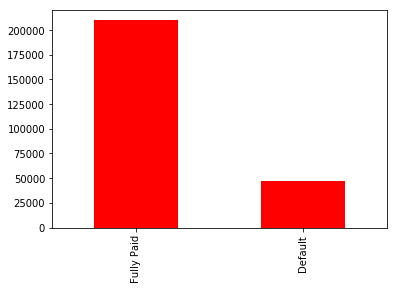

In [21]:
(Loan_details_final['loan_status'].value_counts()).plot(kind='bar', color="red")

In [22]:
Loan_details_final['verification_status'].value_counts()

Verified           94002
Not Verified       88174
Source Verified    74763
Name: verification_status, dtype: int64

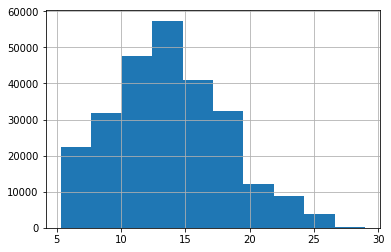

In [23]:
Loan_details_final['int_rate'].hist()

In [25]:
Loan_details_final['term'].value_counts()

 36 months    199811
 60 months     57128
Name: term, dtype: int64

In [26]:
Loan_details_final['grade'].value_counts()

B    76617
C    66309
A    42441
D    41509
E    19923
F     7986
G     2154
Name: grade, dtype: int64

# Finding duration of the loan so far

In [27]:
Loan_details_final['Last_Payment'] = Loan_details_final['last_pymnt_d'].apply(lambda x : datetime.strptime(x,'%b-%Y'))
Loan_details_final['Issue_Date'] = Loan_details_final['issue_d'].apply(lambda x : datetime.strptime(x,'%b-%Y'))

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
Loan_details_final['Duration'] = (Loan_details_final['Last_Payment'] - Loan_details_final['Issue_Date'])

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
Loan_details_final['Duration'] = Loan_details_final['Duration'].apply(lambda x: x.days)

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
Loan_details = Loan_details_final.drop(['Last_Payment','Issue_Date','last_pymnt_d','issue_d','zip_code','next_pymnt_d','earliest_cr_line','last_credit_pull_d'],axis = 1)

# Label Encoding the Categorical Features

In [32]:
categorical = Loan_details_final.select_dtypes(include=[object]).columns

In [33]:
loan_details = Loan_details_final[categorical].apply(LabelEncoder().fit_transform)

# Spliting data into test- train

In [34]:
train,test = cross_validation.train_test_split(loan_details,test_size = 0.3,random_state = 0)

In [35]:
x_train = train.drop('loan_status',axis = 1)
y_train = train['loan_status']
x_test = test.drop('loan_status',axis = 1)
y_test = test['loan_status']

# Fitting the Model

In [36]:
classifier_LR = LogisticRegression(penalty='l2',random_state = 0)
classifier_RF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier_SVC = SVC(kernel = 'rbf', random_state = 0)
classifier_KNN = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2)

# Logistic Regression

In [37]:
classifier_LR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
predict_LR = classifier_LR.predict(x_test)

In [39]:
accuracy_LR = (predict_LR == y_test).mean()
accuracy_LR

0.81149944215251291

# Random Forest

In [40]:
classifier_RF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [46]:
predict_RF = classifier_RF.predict(x_test) #Prediction in Test Set

In [47]:
accuracy_RF = (predict_RF == y_test).mean()
accuracy_RF

0.83874315663838506

# K-Nearest Neighbour

In [43]:
classifier_KNN.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [48]:
predict_KNN = classifier_KNN.predict(x_test)

In [50]:
accuracy_KNN = (predict_KNN == y_test).mean()
accuracy_KNN

0.80454580835992839

# Light Gradient Boosting